# Step 4: Processing Bayesian inference and semi-empirical calibration results

The results from the previous McMC run are processed in more detail here.
 - The parameter chain values for each parameter (with the iteration as x-axis).
 - Kernel Density Estimate using samples of chain (considering number of burn-in samples). This estimates the posterior PDF from its samples.
 - TF (data, model initial guess, model best guess).

Other valuable visualisations exist and are implemented either in the ParaMonte, Arviz, etc. Pyton packages, such as the auto-correlation function (the correlation between samples).

In [63]:
# Import required packages.
# - Plot figures inline with text in this notebook.
%matplotlib inline
# - Higher DPI figures.
%config InlineBackend.figure_format='retina'
import os
import copy
import pickle
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import Source.BerghTijdemanWhitmoreModels as tt_m  # Analytical models.
from Source.ProcessingFunctions import frequency_response  # Complex TF to amplitude and phase of TF.
from Source.CalibrationMeasurement import PressureAcquisition
from Source.PlottingFunctions import plot_transfer_function_df, plot_chain_df, plot_kde_df

The output of the McMC run in *Step3_semi_empirical_calibration.ipynb* is saved in a file.
The variable names provided in that previous notebook, i.e., 'alpha' and 'vv_vt', are also not the labels that one wishes to use for plotting.
Hence, the following two inputs.

In [64]:
# File containing McMC samples.
F_MCMC = os.path.join('.', 'Media', 'McMC_results.pickle')

# For plotting. Converts parameter labels strings defined in McMC sample file into strings used for figures.
dct_par_labels = {'alpha': r'$|\alpha| \omega^{-1/2}$, s$^{1/2}$', 'vv_vt': r'$V_v/V_t$, -'}

In [65]:
# Load McMC data.
with open(F_MCMC, 'rb') as handle:
    dct_mcmc = pickle.load(handle)

df_d = dct_mcmc['DATA']  # Measurement data.
alpha_chain = dct_mcmc['alpha_chain']  # Parameter sample chain.
log_posterior_chain = dct_mcmc['rho_chain']  # Posterior logarithmic PDF of all the samples.

# Save the array of parameter values into a Pandas DataFrame.
df_chain = pd.DataFrame(alpha_chain, columns=dct_mcmc['MCMC_SETTINGS']['PAR_STR'])
df_chain.columns = [dct_par_labels[key_i] for key_i in df_chain.columns]

f_arr = df_d.index.to_numpy(float)  # Frequencies used for model.
norm_param = dct_mcmc['MCMC_SETTINGS']['ALPHA_FULL']  # Full array of initial parameter values.
gamma, pr = dct_mcmc['CONDITIONS']['GAMMA'], dct_mcmc['CONDITIONS']['PR']  # Model conditions.

The two relevant sets of parameter values are:
1. The initial guess parameters.
2. The best guess parameters, also known as the **maximum a posteriori (MAP)**.

In [66]:
# Initial guess fitting parameters.
alpha_0 = norm_param[1:]
# Best fitting parameters (MAP: Maximum A Posteriori).
alpha_map = alpha_chain[np.argmax(log_posterior_chain), :]

## 1. Transfer function

Simply plotting the TF is the first, and possibly most important, visualisation of the McMC. The data is a TF, the model returns TFs, and the aim is to get a good match between both. This match can be observed by the operator by simply plotting all the TFs.

In [67]:
# Define the model again, to run the initial and optimal guess parameters through.
def model_complex(alpha_i, w=2*np.pi*f_arr):
    el_pin = tt_m.Element(k_l_pre=norm_param[0], alpha_pre=alpha_i[0]*1j**1.5, vv_vt=alpha_i[1], gamma=gamma, pr=pr)
    pr_pin = el_pin(w=w)
    pr_pin[np.isnan(pr_pin)] = 1+0j
    return pr_pin


def model(alpha_i, w=2*np.pi*f_arr):
    pr_pin = model_complex(alpha_i=alpha_i, w=w)
    return frequency_response(pr_pin)

For plotting, the TF associated to the initial guess parameters and best guess parameters (MAP) need to be computed.

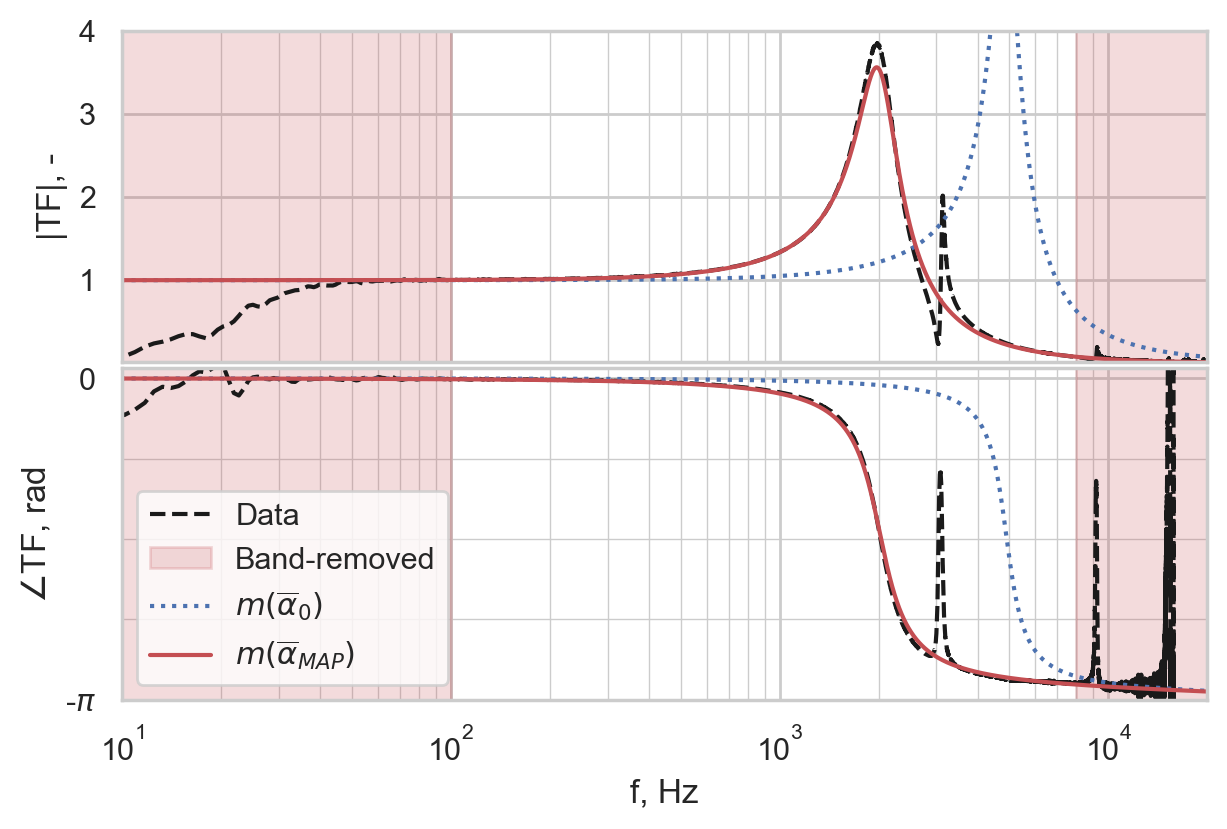

In [68]:
# Model TFs.
amp_m_0, phase_m_0 = model(alpha_i=alpha_0)  # Initial guess.
# Best fitting parameters (MAP: Maximum A Posteriori).
amp_m_map, phase_m_map = model(alpha_i=alpha_map)  # Amplitude and phase of TF.

# Plotting.
fig_tf, ax_tf = plot_transfer_function_df(
    df=df_d, fig_dim=(6, 4), color='k', linestyle='--', alpha=1., legend_loc='lower left',
    minor_phase=0.25, x_lim=(1E1, 2E4), y_lim_amp=(1E-2, 4E0), y_lim_phase=(-1 * np.pi, 0.1))
# Plot band-removed data.
f_band_remove_lst = dct_mcmc['MCMC_SETTINGS']['F_BAND_REMOVE_LST']
for ax_i in ax_tf.flatten():
    y_lim_i = ax_i.get_ylim()
    for (x_lower_limit_i, x_upper_limit_i) in f_band_remove_lst[:-1]:
        ax_i.fill_betweenx(y=y_lim_i, x1=2 * [x_lower_limit_i], x2=2 * [x_upper_limit_i],
                           color='r', alpha=0.2)
    ax_i.fill_betweenx(y=y_lim_i, x1=2 * [f_band_remove_lst[-1][0]], x2=2 * [f_band_remove_lst[-1][1]],
                       color='r', alpha=0.2, label='Band-removed')
# Model TFs.
ax_tf[0].plot(f_arr, amp_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')  # Initial guess.
ax_tf[1].plot(f_arr, phase_m_0, color='b', linestyle=':', label=r'$m(\overline{\alpha}_0)$')
ax_tf[0].plot(f_arr, amp_m_map, color='r', linestyle='-', label=r'$m(\overline{\alpha}_{MAP})$')  # Best guess.
ax_tf[1].plot(f_arr, phase_m_map, color='r', linestyle='-', label=r'$m(\overline{\alpha}_{MAP})$')
ax_tf[1].legend(loc='lower left')
fig_tf.tight_layout(pad=0.1)  # Tries to fill white-space in figure.

## 2. Chain parameter value evolution

The evolution of the parameter values is another interesting metric. As mentioned before, the chain will evolve from the initial guess to a high probability region (close to the MAP), this process is termed 'burn-in'. These burn-in samples are not representative of the posterior PDF, and should therefore not be used in the next visualisation: the Kernel Density Estimate (KDE).

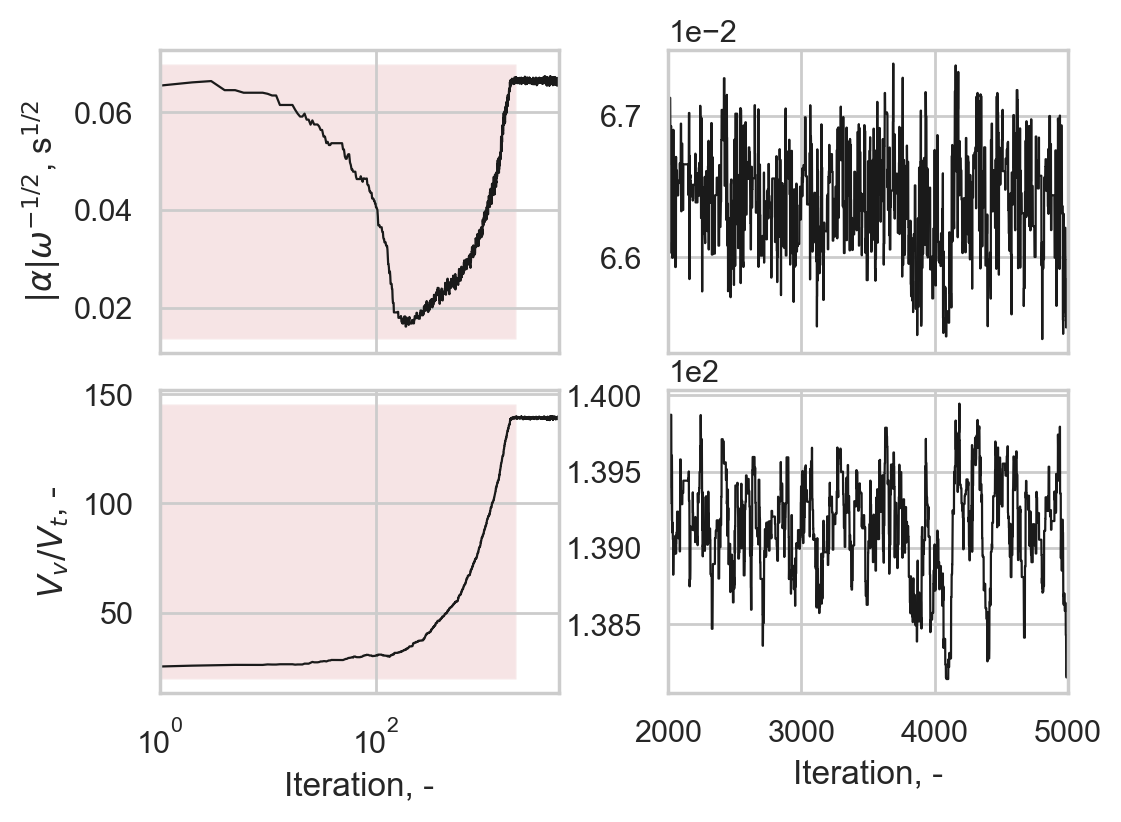

In [69]:
N_BURN_IN = 2000
LOG_MODE = True
fig_chain, ax_chain = plot_chain_df(df=df_chain, n_burn_in=N_BURN_IN, log_mode=LOG_MODE)
[ax_i.grid() for ax_i in ax_chain.flatten()];
fig_chain.tight_layout(pad=0.2)

## 3. Kernel Density Estimate

Lastly, the Kernel Density Estimate (KDE) is a way to use samples, taken according to a PDF, to estimate the underlying PDF. In the case of McMC, the samples are taken based on the value of the posterior at those parameter values. Hence, this is a perfect fit for McMC. The local density of the samples is proportional to the local PDF value. It works similar to a histogram, where the height of the bins estimates the PDF, but in a smoothened manner.

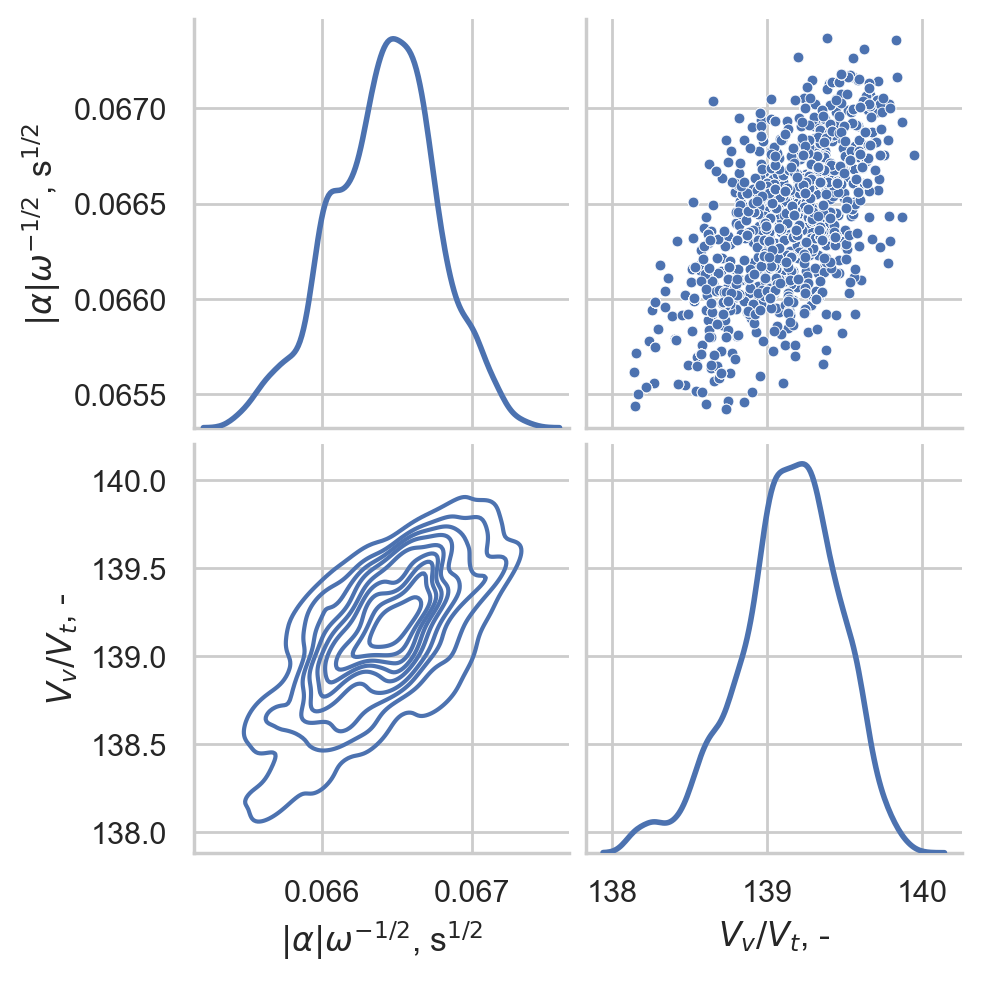

In [70]:
g_kde = plot_kde_df(
    df=df_chain.iloc[N_BURN_IN:, :],
    kwargs_for_pair_grid=None, kwargs_for_seaborn_theme={'style': 'whitegrid'})
g_kde.tight_layout()
g_kde.fig.show()

## Extra: Applying the TF to unsteady pressure measurements

Another interesting way to look at the TF fit, is by applying it to unsteady pressure measurements acquired with the probe. If the measurements are acquired for a benchmark case, such as a zero-pressure gradient turbulent boundary layer flow, then the TF-corrected measurements can be compared to the existing theory. This too can show is the semi-empirical calibration method provides a better calibration than the fully empirical method.

The unsteady wall pressure measurements TDMS file, and the (in this case) single data channel that will be analysed are inputs.

In [71]:
# File path of unsteady-pressure measurements.
FILE_PATH_P_MEASUREMENTS = os.path.join('..', 'TestData', 'BK_Pinhole', 'Fake_example_unsteady_wall_pressure_data.tdms')
CHANNEL_P_MEASUREMENTS = [('Untitled', 'Channel 1')]  # (Single) data channel to analyse.
# Read data.
obj_m = PressureAcquisition(file_path=FILE_PATH_P_MEASUREMENTS, fs=51200, safe_read=False)

For the sake of comparison, the three TFs are applied to the same pressure measurements, to show the impact of differences in the TF.
- *df_d*: Empirical calibration data.
- *df_tf_0*: The semi-empirical calibration method **initial guess** using the data of *df_d*.
- *df_tf_map*: The semi-empirical calibration method **best guess** using the data of *df_d*.

In [72]:
# For now, apply some column names to it. The specific names do not matter.
df_d.columns = ['Data']
df_tf_0 = pd.DataFrame(model_complex(alpha_i=alpha_0), columns=['Initial guess'], index=f_arr)
df_tf_map = pd.DataFrame(model_complex(alpha_i=alpha_map), columns=['Best guess'], index=f_arr)

The object *obj_m*, containing the pressure measurement data, before any TF is applied to it, is copied three times. Afterwards, the three aforementioned TFs can be applied to the various copies of the measurement data.

In [73]:
# Three copies of pressure measurement data object.
obj_m_d = copy.deepcopy(obj_m)
obj_m_0 = copy.deepcopy(obj_m)
obj_m_map = copy.deepcopy(obj_m)
# Correct all copies with a different TF.
obj_m_d.set_transfer_function(df_tf=1/df_d, dct_channel_transfer_function=dict(zip(CHANNEL_P_MEASUREMENTS, df_d.columns)), axis=0)
obj_m_0.set_transfer_function(df_tf=1/df_tf_0, dct_channel_transfer_function=dict(zip(CHANNEL_P_MEASUREMENTS, df_tf_0.columns)), axis=0)
obj_m_map.set_transfer_function(df_tf=1/df_tf_map, dct_channel_transfer_function=dict(zip(CHANNEL_P_MEASUREMENTS, df_tf_map.columns)), axis=0)

Finally, the wall pressure spectra (WPS) can be compared. Any of the four below graphs can be commented or uncommented to see more the initial guess TF and the WPS without TF.

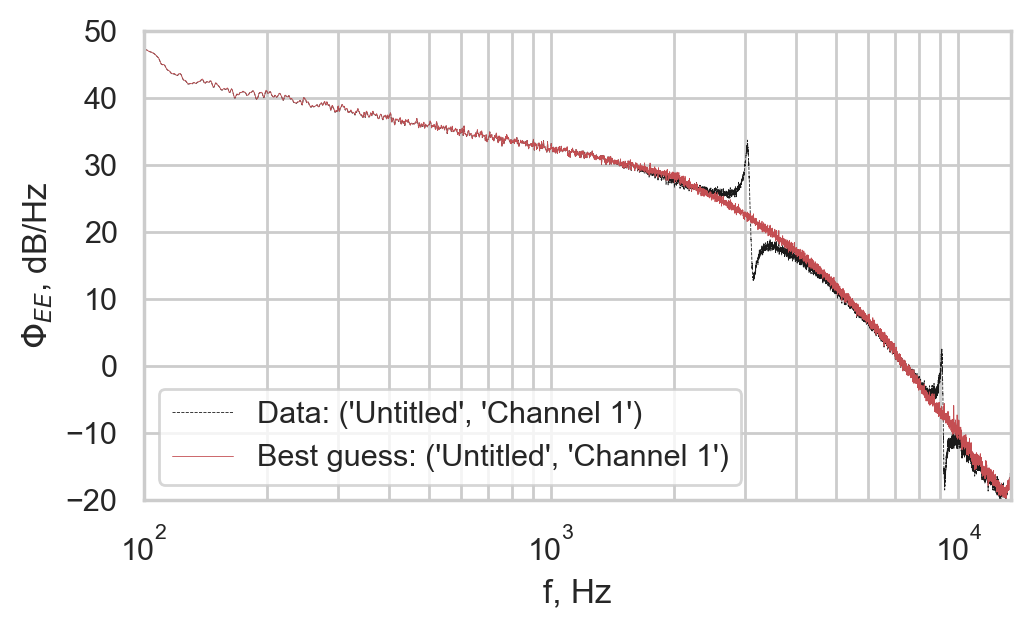

In [74]:
# *** Plot all the data, with the desired TFs. Can comment or uncomment all but the topmost one (which defines fig_wps_m and ax_wps_m). ***
# Empirical calibration TF. Also define fig_wps_m and ax_wps_m.
_, (fig_wps_m, ax_wps_m) = obj_m_d.psd_norm(which=CHANNEL_P_MEASUREMENTS, visualise=True, fig_dim=(5, 3),
                                            alpha=1., linewidth=0.3, color='k', linestyle='--', prefix='Data: ')
# NO TF.
'''
_ = obj_m.psd_norm(which=CHANNEL_P_MEASUREMENTS, visualise=True, ax=ax_wps_m, alpha=1.,
                   linewidth=0.3, color='g', linestyle='-.', prefix='w/o TF: ')
'''
# Initial guess TF.
'''
_ = obj_m_0.psd_norm(which=CHANNEL_P_MEASUREMENTS, visualise=True, ax=ax_wps_m, alpha=1.,
                     linewidth=0.3, color='b', linestyle=':', prefix='Initial guess: ')
'''
# Best guess TF. Also set axis limits, axis labels, etc.
_ = obj_m_map.psd_norm(which=CHANNEL_P_MEASUREMENTS, visualise=True, ax=ax_wps_m, alpha=1.,
                       linewidth=0.3, color='r', linestyle='-',
                       legend_loc='lower left', y_str=r"$\Phi_{EE}$, dB/Hz", x_scale='log',
                       x_lim=(1E2, 13.5E3), y_lim=(-20, 50), prefix='Best guess: ')
fig_wps_m.tight_layout(pad=0.1)

The method completely removes spurious resonance in the WPS at 3 kHz and 9 kHz, making the WPS look a lot more canonical, i.e., a linear lower-frequency part (in this log-log plot), with a gradual transition to a linear steeper decay in energy in the higher-frequencies.

This example is artificial, as mentioned in the dataset. It is derived from a TF-corrected WPS acquired with a different microphone probe. The corrected WPS then has the TF of this probe applied to it (processed with the semi-empirical calibration method), to results in 'TF uncorrected' unsteady wall-pressure measurements.
Still, the spurious resonance in microphone calibration and its impact on any TF-corrected measurement data is clear, i.e., the propagation of error. And the presented semi-empirical method can be a useful tool in improving the calibration data, and hence the pressure measurements.